# Titanic Survival Prediction  
## Model Training and Evaluation

This notebook trains multiple machine learning models to predict passenger survival on the Titanic.
It includes preprocessing, baseline models, hyperparameter tuning, a neural network, and model evaluation.


## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

## 2. Data Loading and Preprocessing

In [2]:
df = pd.read_csv('/content/titanic.csv')
df.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### Feature Engineering

In [3]:
df['family_size'] = df['sibsp'] + df['parch'] + 1
df['is_alone'] = (df['family_size'] == 1).astype(int)
df['age_class'] = df['age'] * df['pclass']


### Handling Missing Values

In [4]:
df['age'].fillna(df['age'].median(), inplace=True)
df['fare'].fillna(df['fare'].median(), inplace=True)
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)


### Feature Selection and Encoding


In [5]:
features = [
    'pclass', 'sex', 'age', 'sibsp', 'parch',
    'fare', 'embarked', 'family_size', 'is_alone'
]

X = df[features].copy()
y = df['survived']

le_sex = LabelEncoder()
le_embarked = LabelEncoder()

X['sex'] = le_sex.fit_transform(X['sex'])
X['embarked'] = le_embarked.fit_transform(X['embarked'])


### Train-Test Split and Scaling

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.shape, X_test.shape


((712, 9), (179, 9))

## 3. Baseline Model Training

In [7]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

results = {}


In [8]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_proba)
    }

pd.DataFrame(results).T


,Accuracy,Precision,Recall,F1,AUC
Logistic Regression,0.810056,0.786885,0.695652,0.738462,0.858630
Decision Tree,0.782123,0.720588,0.710145,0.715328,0.764954
Random Forest,0.804469,0.757576,0.724638,0.740741,0.833729
Gradient Boosting,0.804469,0.803571,0.652174,0.720000,0.819829
XGBoost,0.793296,0.735294,0.724638,0.729927,0.805007


## 4. Hyperparameter Tuning — Random Forest

In [9]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(
    rf,
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train_scaled, y_train)

grid_search_rf.best_params_, grid_search_rf.best_score_


Fitting 5 folds for each of 108 candidates, totalling 540 fits


({'max_depth': None,
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 300},
 np.float64(0.8231458682162909))

In [11]:
best_rf = grid_search_rf.best_estimator_
accuracy_score(y_test, best_rf.predict(X_test_scaled))

0.7988826815642458

## 6. Neural Network Model

In [12]:
nn_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [13]:
history = nn_model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)


In [14]:
y_pred_nn_proba = nn_model.predict(X_test_scaled).flatten()
y_pred_nn = (y_pred_nn_proba > 0.5).astype(int)

accuracy_score(y_test, y_pred_nn), roc_auc_score(y_test, y_pred_nn_proba)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


(0.7988826815642458, np.float64(0.8527009222661396))

### Neural Network Training Curves

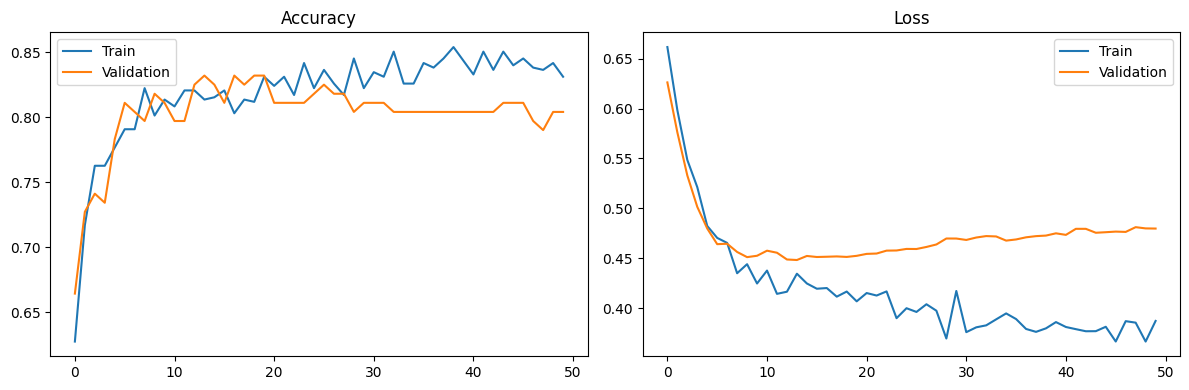

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 7. Feature Importance (Random Forest)

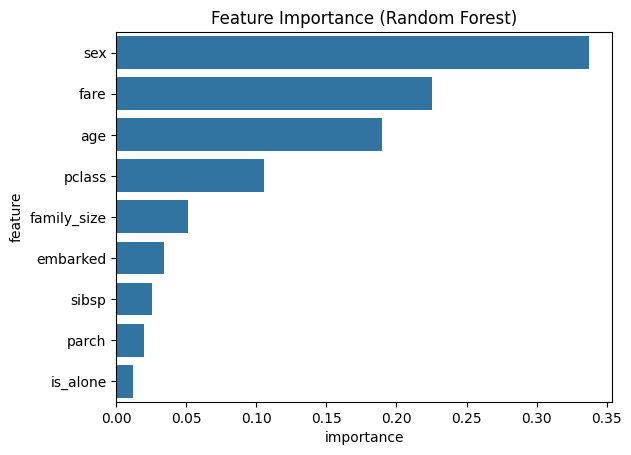

In [16]:
feature_importance = (
    pd.DataFrame({
        'feature': features,
        'importance': best_rf.feature_importances_
    })
    .sort_values('importance', ascending=False)
)

sns.barplot(
    data=feature_importance,
    x='importance',
    y='feature'
)
plt.title('Feature Importance (Random Forest)')
plt.show()


## 8. Confusion Matrix and ROC Curve (XGBoost)

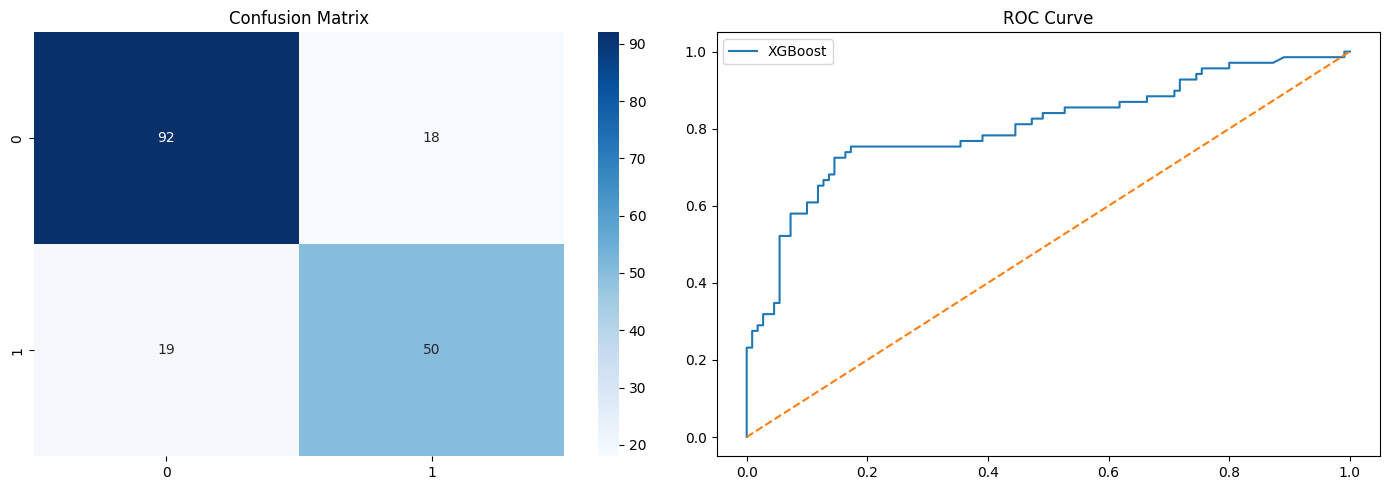

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_test, models['XGBoost'].predict(X_test_scaled))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')

fpr, tpr, _ = roc_curve(
    y_test,
    models['XGBoost'].predict_proba(X_test_scaled)[:, 1]
)

axes[1].plot(fpr, tpr, label='XGBoost')
axes[1].plot([0, 1], [0, 1], '--')
axes[1].set_title('ROC Curve')
axes[1].legend()

plt.tight_layout()
plt.show()

## 9. Save Final Model and Preprocessing Objects

In [20]:
joblib.dump(best_rf, '../model.pkl')
joblib.dump(scaler, '../scaler.pkl')
joblib.dump(le_sex, '../le_sex.pkl')
joblib.dump(le_embarked, '../le_embarked.pkl')

print("Models and preprocessing objects saved successfully.")

Models and preprocessing objects saved successfully.
